<a href="https://colab.research.google.com/github/clam004/buddy/blob/main/START_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
from scipy.spatial.distance import cdist   
from matplotlib import pyplot as plt 

%load_ext autoreload
%autoreload 2
%matplotlib inline

Part 1 and 2 are basic data science skills questions, the main project is in the last parts, Part 3 and 4. 

# Part 1 

Change the code below, ie the [variances and covariances](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.multivariate_normal.html), to make the data distribution of x closer to this image:

<img src="https://raw.githubusercontent.com/clam004/buddy/main/upperleft.png" height=500 width=500>

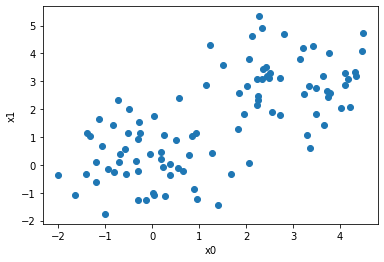

In [ ]:
# Part 1:

# number of samples per cluster
pts = 50 

# random number generator
rng = np.random.default_rng()

a = rng.multivariate_normal(
    mean=[3,3], 
    cov=[[1,0],
         [0,1]], 
    size=pts,
)

b = rng.multivariate_normal(
    mean=[0,0], 
    cov=[[1,0],
         [0,1]], 
    size=pts,
)

x = np.concatenate((a, b))

# Plot data 
plt.scatter(x[:, 0], x[:, 1])
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

# Part 2

Fix the bug in this k-mean clustering function, use it to cluster the combined data `x` (not `a` and `b`) then plot the resulting color labeled clusters like this:

<img src="https://raw.githubusercontent.com/clam004/buddy/main/Q2.png" height=500 width=500>

Add Comments `#like this ` to show where the changes you made are, and to explain how the function now works correctly

In [ ]:
# Part 2:

def kmeans(x, k, no_of_iterations):  
    
    """ Function to implement k-means clustering 
    # x is a (num_samples, 2) numpy array 
    # k is number of clusters 
    # no_of_iterations is the number of iterations to run k means
    """
    
    # Randomly choose initial Centroids 
    idx = np.random.choice(len(x), k, replace=False)         
    
    centroids = x[idx, :]       
    distances = cdist(x, centroids ,'euclidean')          
    points = np.array([np.argmax(i) for i in distances])  
    
    # main loop
    for _ in range(no_of_iterations):  
        
        centroids = []      
        
        for idx in range(k):     
            
            temp_cent = x[points==idx].mean(axis=1)   
            centroids.append(temp_cent) 
            centroids = np.vstack(centroids)  
            distances = cdist(x, centroids ,'euclidean')    
            
        points = np.array([np.argmax(i) for i in distances])              
            
    return points

# use function
points = kmeans(x,k=2,no_of_iterations=10)

# assign clusters
cluster1 = x[points==0]
cluster2 = x[points==1]

# Plot the data in labeled clusters 
plt.scatter(cluster1[:, 0], cluster1[:, 1])
plt.scatter(cluster2[:, 0], cluster2[:, 1])
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

# Part 3

## Intro to Part 3

We will be retraining the autoregressive large language model, also known as causal language model, GPT2 from this paper [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) to perform some new tasks for us. Here is an explanatory video by Huggingface of the [Decoders or autoregressive models](https://youtu.be/d_ixlCubqQw), not to be confused with the Encoders or autoencoding models. Here is a [blog and tutorial](https://towardsdatascience.com/guide-to-fine-tuning-text-generation-models-gpt-2-gpt-neo-and-t5-dc5de6b3bc5e) that explains one way to implement many of the same tools needed to solve this project. 

We have provided some starter code below and in `utils.py` that shows how we can load a pretrained large language model.

In `utils.py` you will find a rudimentary class called `BaseAgent` with a class method called `memorize` that can be used to retrain (aka finetune) the model. This is not the best way to finetune, but it can be used as starter code to a new method that can finetune the model. 

In the cells below, I demonstrate how this class is used to overlearn, aka memorize, one conversational example, aka one sample.

## GPU acceleration

To give yourself a GPU in colab, go to `Runtime`-->`Change runtime type`

You can confirm this worked because `torch.cuda.device_count()` will change from 0 to the number of GPUs PyTorch now recognizes, this would be 0 to 1 in colab. 

In [ ]:
%%capture
! pip install transformers datasets

In [ ]:
#sys libs
import os
import sys
import random
import time
import re
import json

#data manupulation libs
import numpy as np

#string manupulation libs
import re
import string

#torch libs
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print('torch.cuda.device_count()', torch.cuda.device_count())
print('torch.cuda.empty_cache()', torch.cuda.empty_cache())

#huggingface transformers
import transformers
from transformers import set_seed
from transformers import GPT2Tokenizer, GPT2LMHeadModel

print(transformers.__version__)

# seeds
set_seed(42)
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

%load_ext autoreload
%autoreload 2
%matplotlib inline

torch.cuda.device_count() 1
torch.cuda.empty_cache() None
4.20.1


In [ ]:
class BaseAgent(torch.nn.Module):

    def __init__(self, tokenizer, model):
        
        super().__init__()
        
        self.model = model
        self.tokenizer = tokenizer
        self.optimizer = torch.optim.Adam(
            model.parameters(),
            lr=0.00005,
            betas=(0.9, 0.98),
            eps=1e-9,
        )
        
        self.num_gpus = torch.cuda.device_count()
        
        if self.num_gpus > 1:
            self.model.parallelize()
        elif self.num_gpus == 1:
            self.model = self.model.cuda()
        
    def get_response(self, prompt, max_len = 32):
        
        prompt_ids = self.tokenizer.encode(
            prompt,
            return_tensors="pt",
        )
        
        if self.num_gpus > 0:
            prompt_ids = prompt_ids.cuda()
        
        prompt_len = prompt_ids.shape[1]
        
        output_ids = self.model.generate(
            prompt_ids,
            max_length=prompt_len+max_len,
        )

        generated_text = self.tokenizer.batch_decode(output_ids)[0]
        
        return generated_text
    
    def memorize(self, prompt, num_epochs = 3):

        print('start training loop')

        """ This is a rudimentary training loop
        that will train the agent to learn one
        sequence, the prompt. With enough epochs, this should
        result in memorizing the sequence, which is why this
        class method was names memorize. 
        There is nothing returned because the model attribute is modified inplace. 
        Args:
            prompt (string): the text to be learned
            num_epochs (int): the number of times we cycle though the training data, only 1 sample in this case
        """

        
        
        prompt_dic = self.tokenizer(prompt,return_tensors="pt")
        prompt_ids = prompt_dic.input_ids
        prompt_mask = prompt_dic.attention_mask
        prompt_len = prompt_ids.shape[1]

        if self.num_gpus > 0:
            prompt_ids = prompt_ids.cuda()
            prompt_mask = prompt_mask.cuda()
            
        source_ids = prompt_ids[:,:-1]
        target_ids = prompt_ids[:,1:]
        source_mask = prompt_mask[:,:-1]
        target_mask = prompt_mask[:,1:]

        # allow params to be updated
        self.model.train()

        for e in range(num_epochs):

            # Forward Pass
            output = self.model(
                input_ids = source_ids,
                attention_mask = source_mask,
            )

            # used logits and target tokens to calculate the loss
            logits = output.logits

            scalar_loss = cross_entropy_loss(
                logits, 
                target_ids, 
            )

            # backward pass
            self.optimizer.zero_grad()
            scalar_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            print("epoch", e, "loss", scalar_loss.item())


def cross_entropy_loss(logits, target_ids):
    
    """
    For F.cross_entropy the Input is shape (N, C), where N = batch_size x sequence_length
    and C is the number of classes, in our case C is the number of tokens in the vocabulary
    Target is shape (N).
    https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html
    we flatten the batch dimension together with the max_seq length
    so that for the loss funstion, so afterwards, there is no batch dimension,
    just a vector sized C-dimensions for each of the seq_len tokens. 
    If there had been 2 sampels with a batch size of 2, with 3 tokens in each sample
    then the predictions.shape would be torch.Size([6, 50257])
    Args:
        logits (torch.tensor, float): shape [batch_size, sequence_length, vocab_size]
        target_ids (torch.tensor, int): shape [batch_size, sequence_length]
    Returns: 
        scalar_loss (torch.tensor, scalar float, grad_fn=<NllLossBackward0>)): no shape
            this is a loss you can backpropagate using:
            optimizer.zero_grad()
            scalar_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
    """
    
    predictions = logits.view(-1, logits.size(-1))
    target = target_ids.view(-1)

    scalar_loss = F.cross_entropy(
        predictions,
        target,
    )

    return scalar_loss

In [ ]:
# download the gpt transformer tokenizer

pretrained_hf_model = 'gpt2'

tokenizer = GPT2Tokenizer.from_pretrained(
    pretrained_hf_model,
    pad_token='<|endoftext|>',
)


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
# download the gpt transformer model and tokenizer

pretrained_hf_model = 'gpt2'

cache_dir = os.path.join(
    "./modelstates/hugface_models/",
    pretrained_hf_model,
)

print("cache_dir=", cache_dir)

model = GPT2LMHeadModel.from_pretrained(
    pretrained_hf_model,
    cache_dir=cache_dir,
)

cache_dir= ./modelstates/hugface_models/gpt2


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [ ]:
# place the model and tokenizer into our dialog agent

agent = BaseAgent(
    tokenizer = tokenizer,
    model = model,
)

# check where our model is
next(model.parameters()).device

device(type='cuda', index=0)

In [ ]:
# an example of how the pretrained model can extend dialog

generated_text = agent.get_response(
    prompt = "A: Hello.\nB: Hi.\nA: How was your day?\nB:",
    max_len = 64
)

print(generated_text)

generated_text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


A: Hello.
B: Hi.
A: How was your day?
B: I was in the office.
A: How did you get there?
B: I was in the office.
A: How did you get there?
B: I was in the office.
A: How did you get there?
B: I was in the office.
A: How


'A: Hello.\nB: Hi.\nA: How was your day?\nB: I was in the office.\nA: How did you get there?\nB: I was in the office.\nA: How did you get there?\nB: I was in the office.\nA: How did you get there?\nB: I was in the office.\nA: How'

#### Hint:

Suppose you want to learn the sequence

**all dogs are good boys**

and suppose you are using word tokenization instead of subword or byte pair encoding

Then the target sequence, aka labels, aka `y`, aka target output would be the source sequence, aka input sequence, aka `x`, just shifted to the right by one position

source: **all dogs are good**

target: **dogs are good boys**

this is why in `memorize` you see thise lines doing the same as above

```python
        source_ids = prompt_ids[:,:-1]
        target_ids = prompt_ids[:,1:]
        source_mask = prompt_mask[:,:-1]
        target_mask = prompt_mask[:,1:]
```

In [ ]:
# an example of how to learn to extend in a directed manner

agent.memorize(
    "A: Hello.\nB: Hi.\nA: How was your day?\nB: First, you tell me about your day.",
    num_epochs = 5,
)

start training loop
epoch 0 loss 2.560251235961914
epoch 1 loss 2.325902223587036
epoch 2 loss 1.530795931816101
epoch 3 loss 1.2295595407485962
epoch 4 loss 1.2493082284927368


In [ ]:
# how did our retraining change the model?

generated_text = agent.get_response(
    prompt = "A: Hello.\nB: Hi.\nA: How was your day?\nB:",
    max_len = 64
)

print(generated_text)

generated_text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


A: Hello.
B: Hi.
A: How was your day?
B: First, you tell me about your day.
A: First, you tell me about your day.
B: First, you tell me about your day.
A: First, you tell me about your day.
B: First, you tell me about your day.
A: First, you tell


'A: Hello.\nB: Hi.\nA: How was your day?\nB: First, you tell me about your day.\nA: First, you tell me about your day.\nB: First, you tell me about your day.\nA: First, you tell me about your day.\nB: First, you tell me about your day.\nA: First, you tell'

## Data for Part 3

Next lets introduce you to the dataset you will be using for this project. This is a text dataset with multiple conversations, or dialogs, where one of the individuals is acting very empathetically towards the other, and each dialog is labeled by the emotion in that dialog, ie one of 32 different emotions: 

```python
emotion_list = ['sentimental', 'afraid', 'proud', 'faithful', 'terrified', 'joyful', 
                'angry', 'sad', 'jealous', 'grateful', 'prepared', 'embarrassed', 'excited', 
                'annoyed', 'lonely', 'ashamed', 'guilty', 'surprised', 'nostalgic',
                'confident', 'furious', 'disappointed', 'caring', 'trusting', 'disgusted', 
                'anticipating', 'anxious', 'hopeful', 'content', 'impressed', 'apprehensive', 
                'devastated']

len(emotion_list) # 32
```
here are instructions on how to download and unzip that dataset

```console 
wget https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz

tar -xvf empatheticdialogues.tar.gz

rm empatheticdialogues.tar.gz
```

The unzipped folder has a training, validation and test set split

```
os.listdir(path_to_empatheticdialogues)

# ['train.csv', 'test.csv', 'valid.csv']
```

you can load the train dataset like this

```python
splitname = "train"
df = open(os.path.join(path_to_empatheticdialogues, f"{splitname}.csv")).readlines()
print(df[0].strip().split(","))

# ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags']
```

the emotion is under the `context` column, the topic of the conversation is under the `prompt` column, and each speaker's utterance, aka conversational turn, is under the `utterance` column.

```python
for i in range(1, len(df)):
    
    data_line = df[i].strip().split(",")
    
    context = data_line[2]
    prompt = data_line[3].replace("_comma_", ",")
    
print(prompt, " <EMOTION_TYPE> ", context, ' <|endoftext|>')

# I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world. <EMOTION_TYPE> sentimental <|endoftext|>
```

Hint:

With some edits to the training data, a autoregressive model can be turned into a sentiment analysis classifier. Instead of predicting a set of logits for your different classes, like a sentiment classifier, or predicting the next token, like an autoregressive model, have the model predict the right tokens to explain to you what class of emotion the preceding text is (which of the 32 emotions in this case) as the last tokens of a sequence. Use special tokens like `<EMOTION_TYPE>` and `<|endoftext|>` to signify the difference between text and special outputs. 

## Goals for Part 3

There are 5 goals for this project:

#### 1. Preprocess the data into a training and validation set (no need for a test set for this minimal project). The preprocessed dataset should be preprocessed in such a way that it can be used to retrain the large language model as an autoregressive sentiment classifier. For example, the model will be passed:

`I am going on my second date with this guy that seems so far to really connect with me, I want to believe this is, you know, "the one".`

and the model is expected to complete the sequence:

`I am going on my third date with this person that seems, so far, to really connect with me. I want to believe this is ... you know ... "the one". <EMOTION_TYPE> hopeful <|endoftext|>`

(You do NOT need to use all the data in the data folder for this project, you do not have to use a specific split of the data, just use enough data to accomplish your goals, and set aside the validation set so that it is valid according to the definition of a validation)

Please make your preprocessing code clean, simple and easy to read and explain. Preferably with examples. 

#### 2. Rewrite the `BaseAgents`'s `memorize` method found in `utils.py` to accomplish the goal of retraining the model as a autoregressive sentiment classifier. 

Feel free to build off of the starter code, it is written in PyTorch to give you full control of the training, but has some major features missing. For example:

 a. you would have to edit it to allow different batch sizes. 
 b. it does not keep track of the train and validation losses
 c. there is no early stopping or model saving built in
 
You also dont have to use the starter code, feel free to use the already built huggingface [trainer](https://huggingface.co/docs/transformers/main_classes/trainer) or [accelerate](https://huggingface.co/docs/accelerate/accelerator), both demonstrated [here](https://huggingface.co/course/chapter7/6?fw=pt)

#### 3.  Add an `evaluator` method that calculates the validation set accuracy, accuracy of predicting the correct emotion. While you are retraining the model, keep track of the validation and training losses for each epoch or each batch, output these 2 arrays of losses for plotting in the next step. Also while you are retraining the model, keep track of the validation and training accuracies for each epoch or each batch, output these 2 arrays of accuracies for plotting in the next step.


you can use something like this code below to plot the training curves in this colab notebook to display for us that the training implementation worked. adding multiple plt.plot() lines plots multiple curves side by side. 

```
#plotting tools
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
plt.plot(val_accs, label='validation')
plt.legend()
plt.show()
```

provided you saved your validation accuracies in val_accs


#### 4. Train the model to become a autoregressive sentiment classifier. Show us the training curve, aka learning curve, plots by displaying it in this notebook.

your learning curve plots should have this general shape for the losses

<img src="https://raw.githubusercontent.com/clam004/buddy/main/trainingcurve.png" height=500 width=500>

the accuracy plot should look like the losses plot above, only flipped upside down.  


#### 5. Show us 4 examples of the model working correctly and 4 examples of the model working incorrectly

`I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world. <EMOTION_TYPE> sentimental <|endoftext|>`

`I have a take home project to present for my technical interview, they told me that its more about how well I teach than it is the model performance but i dunno, im still abit unsure of myself <EMOTION_TYPE> apprehensive <|endoftext|>`

`we really appreciate you spending the time to do this in order to show us your style of problem solving and your style of communicating your reasoning.  <EMOTION_TYPE> grateful <|endoftext|>`

# Question 4 (Optional)

This part is optional, there is no need to do it if you run out of time doing Question 1 thru 3. 

Do something creative and fun with this project and show us. 

For example: 

1. retrain the model to be a more empathetic chatbot and let us talk to the chatbot

```python
 while True:
    tell_bot = input("Human > ")
    bot_reply = talk_to_bot(tell_bot)
    if ("bye" in tell_bot):
        print('Bot > '+ bot_reply + '\n')
        break
    else:
        print('Bot > '+ bot_reply + '\n') 

```



```console
AI: Hello.
Human: Hi.
AI: How was your day?
Human: I just found out i was rejected from that collage I applied to.
AI: Im sorry to hear that, was it one you were really needed to get into?
Human: no, it just hurts my ego.
AI: i also am sad when rejected. the right one for you though is one that will accept you.
Human: what emotion am i feeling?
AI: disappointed
```

2. deploy the chatbot to an API

# Tips

1. put most of your work in `utils.py` and use this notebook for demonstration purposes
2. for important parts of the code, write the code intuitively (reads easily, self-explanatory), with good documentations a comments, see `cross_entropy_loss` in utils.py
3. extra points if the notebook is clean and easy to follow along with even without you presenting it
4. you dont have to train on all the data or use this large of a model if you dont have the compute resources, although [google colab](https://colab.research.google.com/) has free GPUs and this model and data will fit onto a colab notebook just fine. What you do need to be able to do is to explain how you preprocessed the data for training and how you trained the model to produce the learning curves